In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import calendar
import holidays

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'])
df = df[['data', 'nuovi_positivi']]
df['data'] = pd.to_datetime(df['data']).dt.normalize()

today = df['data'].iloc[-1]
tomorrow = today + pd.DateOffset(days=1)

df_italy = df.groupby('data').sum()

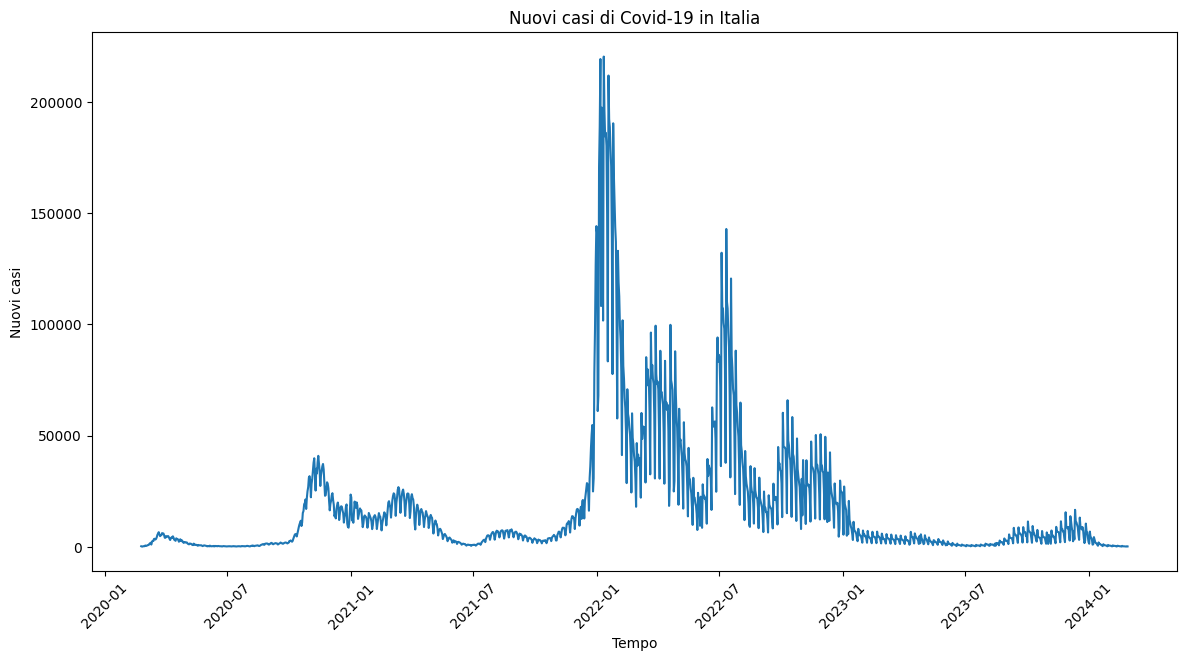

In [3]:
plt.rcParams['figure.figsize'] = [14, 7]
# Create the plot
plt.plot(df['data'].unique(), df_italy['nuovi_positivi'], linestyle='solid')

# Add title and axis labels
plt.title('Nuovi casi di Covid-19 in Italia')
plt.xlabel('Tempo')
plt.ylabel('Nuovi casi')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [4]:
result = adfuller(df_italy.nuovi_positivi.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('lags used: %f' % result[2])
print('observations: %f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.265849
p-value: 0.000509
lags used: 17.000000
observations: 1448.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [5]:
### SARIMAX
is_holiday = [1 if x==True else 0 for x in [day in holidays.Italy() for day in df_italy.index]]

df_italy['holiday'] = is_holiday

results=pm.auto_arima(df_italy.nuovi_positivi, start_p=0, d=None, start_q=0, max_p=3, max_q=3,
                      seasonal=True, m=7, D=None, test='adf', start_P=0, start_Q=0, max_P=3, max_Q=3,
                      information_criterion='aic', trace=True, error_action='ignore',
                      trend=None, exog=df_italy['holiday'],with_intercept=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=34376.777, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=30410.081, Time=1.48 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=32038.857, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=34829.983, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=31949.575, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=31010.492, Time=0.97 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=31010.903, Time=0.50 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=31125.523, Time=0.73 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=33451.589, Time=0.29 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=30233.316, Time=1.23 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=31765.270, Time=0.15 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=30223.736, Time=3.62 sec
 ARIMA(2,0,0)(3,0,0)[7] intercept   : AIC=30825.045, Time=2.70 sec
 ARIMA(2,0,0)(2,0,1)[7] i

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

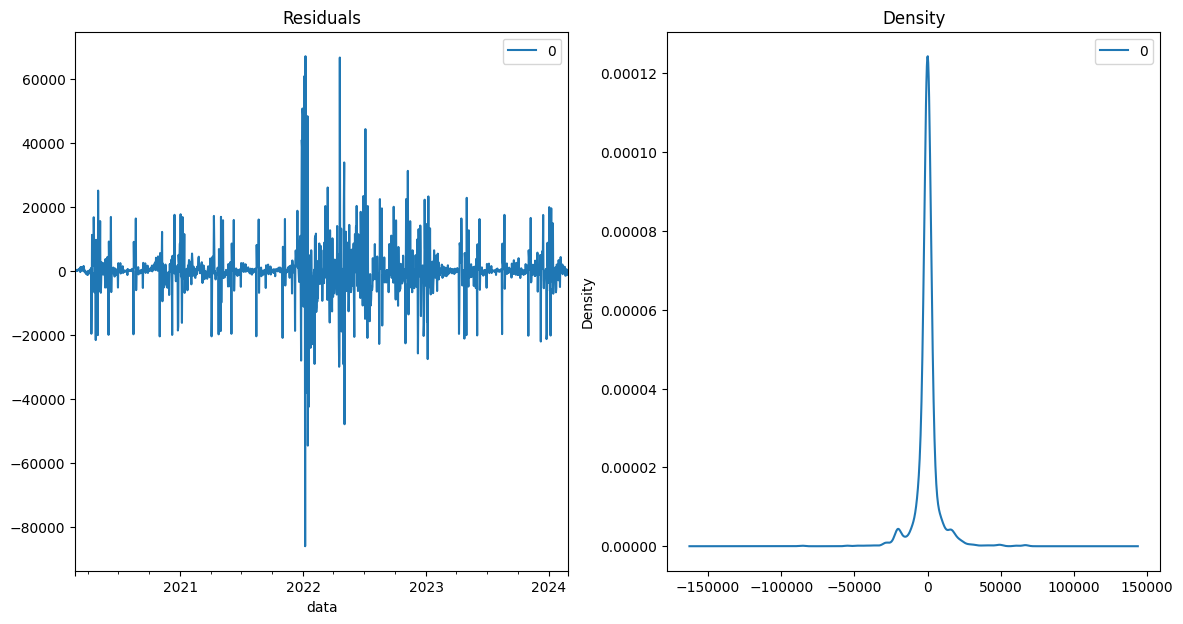

In [6]:
model=SARIMAX(df_italy.nuovi_positivi, order=(2, 0, 1), seasonal_order=(1, 0, 3, 7), exog = df_italy['holiday'])
results=model.fit()
results.summary()
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

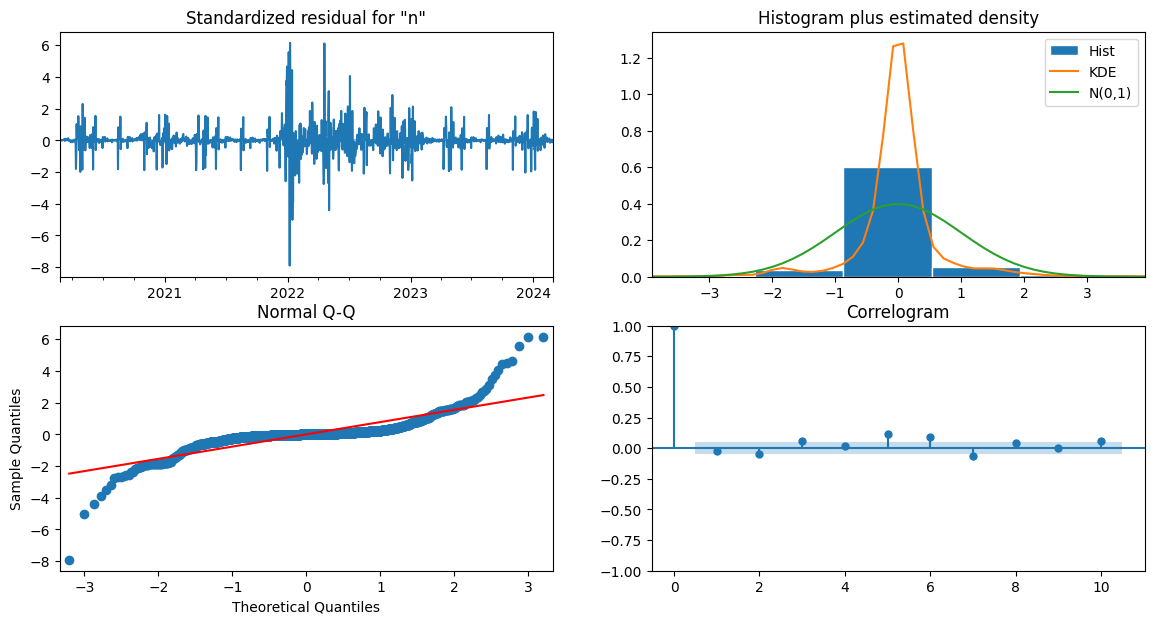

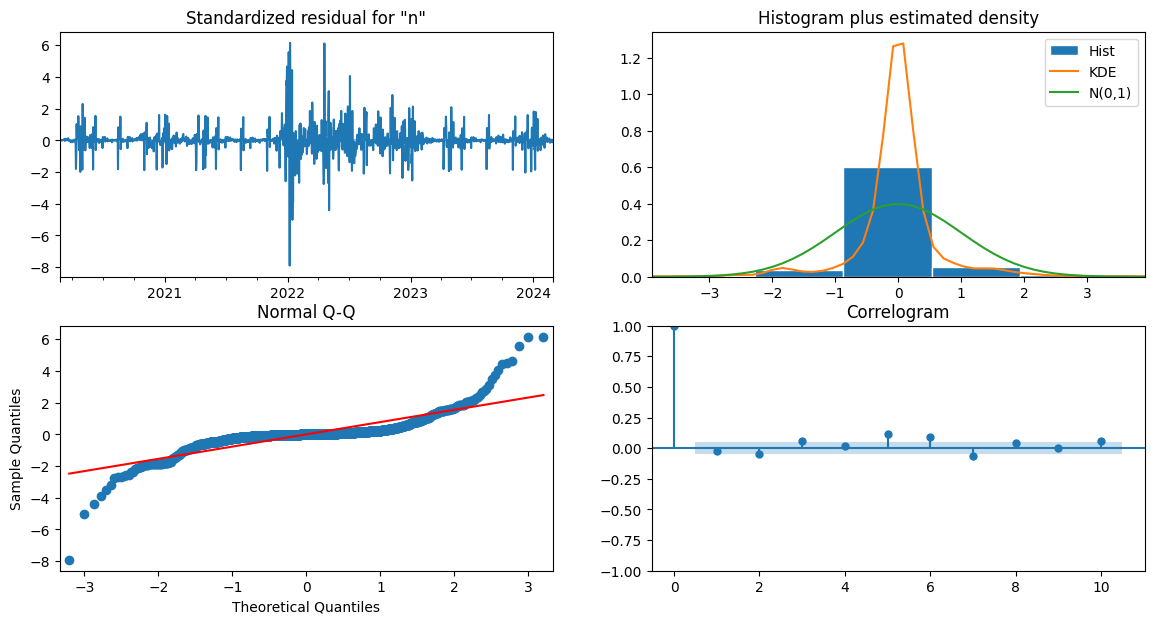

In [7]:
results.plot_diagnostics()

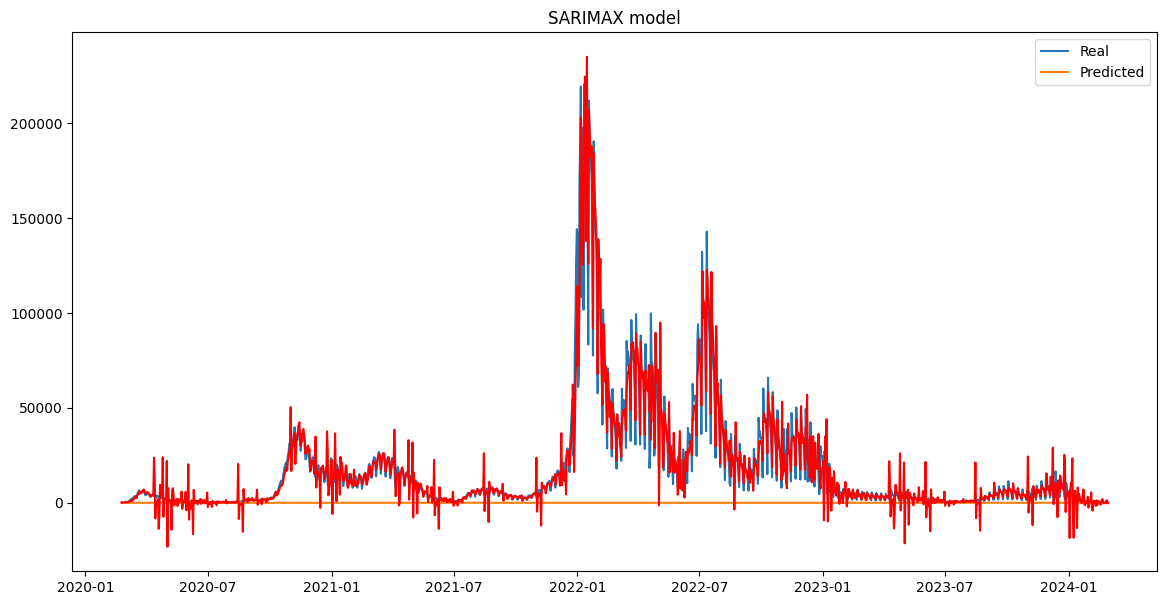

In [8]:
predictions = results.predict(dynamic=False)
plt.plot(df_italy)
plt.plot(predictions, color='red')
plt.title('SARIMAX model')
plt.legend(['Real', 'Predicted'])
plt.show()

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning 

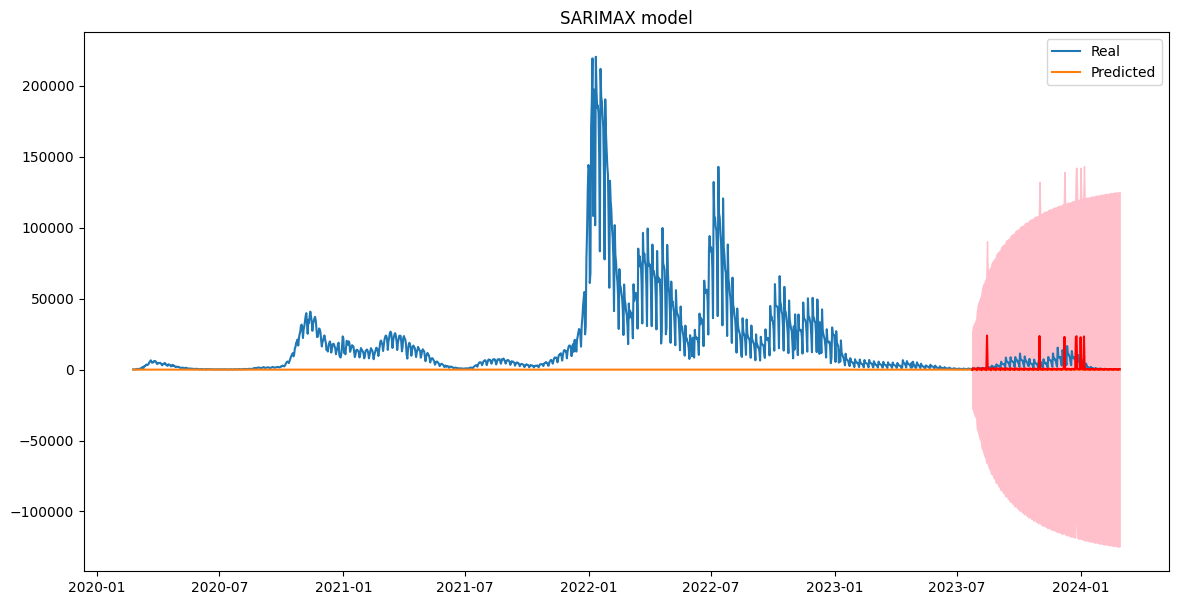

In [14]:
# Split dataset
train = df_italy[:int(0.85*len(df_italy))]
test = df_italy[int(0.85*len(df_italy)):]

# Model
model = SARIMAX(endog=train.nuovi_positivi, exog=train.holiday, order=(2, 0, 1), seasonal_order=(1, 0, 3, 7))
fitted = model.fit()

forecast_window = len(df_italy) - int(0.85*len(df_italy)) # forecasting window

forecast = fitted.get_forecast(steps=forecast_window, exog = df_italy['holiday'].iloc[-forecast_window:], alpha=0.05)
mean_forecast = forecast.predicted_mean

#Confidence Intervals for forecasting
confi_int_f = forecast.conf_int()
lower_limits_f = confi_int_f.iloc[:,0]
upper_limits_f = confi_int_f.iloc[:,1]
sarimax_forecast = pd.DataFrame({'yhat':mean_forecast, 'y_lower':lower_limits_f, 'y_upper':upper_limits_f})

plt.plot(df_italy, label='Observed')
plt.plot(sarimax_forecast['yhat'], color='red', label='Predicted')
plt.fill_between(sarimax_forecast.index, sarimax_forecast['y_lower'], sarimax_forecast['y_upper'], color='pink')
plt.title('SARIMAX model')
plt.legend(['Real', 'Predicted'])
plt.show()